Load Chrome history and clean data

In [83]:
import json
import pandas as pd
import re

with open('Chrome_History.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
    
file.close()
df = pd.DataFrame(data['Browser History'])

# dropping columns I won't use
df.drop(columns=['favicon_url', 'page_transition_qualifier', 'title', 'client_id'], inplace=True)

# changing usec to date amd time
df['time_usec'] = pd.to_numeric(df['time_usec'])
df['datetime'] = pd.to_datetime(df['time_usec'], unit='us')

df['datetime'] = df['datetime'].dt.tz_localize('UTC')

# Convert the 'datetime' to EST (America/New_York)
df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')

# filter data to only include one month
start_date = '2025-01-25'
end_date = '2025-02-17'
df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

df['date'] = df['datetime'].dt.date  # Extract date
df['time'] = df['datetime'].dt.time  # Extract time
df.drop(columns=['time_usec'], inplace=True)

#print(df.head())
#df['url'] = df['time_usec'].astype(str)
df

url  \
1079  https://www.gradescope.com/courses/943014/ques...   
1080  https://www.gradescope.com/courses/943014/ques...   
1081  https://www.gradescope.com/courses/943014/ques...   
1082  https://www.gradescope.com/courses/943014/ques...   
1083  https://www.gradescope.com/courses/943014/ques...   
...                                                 ...   
8389  https://outlook.office.com/mail/inbox/id/AAQkA...   
8390                   https://outlook.office.com/mail/   
8391  https://login.microsoftonline.com/common/oauth...   
8392                   https://outlook.office.com/mail/   
8393    https://calendar.google.com/calendar/u/0/r/week   

                             datetime        date             time  
1079 2025-02-16 23:58:56.780762-05:00  2025-02-16  23:58:56.780762  
1080 2025-02-16 23:58:51.085290-05:00  2025-02-16  23:58:51.085290  
1081 2025-02-16 23:50:50.823248-05:00  2025-02-16  23:50:50.823248  
1082 2025-02-16 23:50:45.089499-05:00  2025-02-16  23:50:45.089499  
1083 2025-02-16 23:44:31.403826-05:00  2025-02-16  23:44:31.403826  
...                               ...         ...              ...  
8389 2025-01-25 15:16:10.813645-05:00  2025-01-25  15:16:10.813645  
8390 2025-01-25 15:16:04.228475-05:00  2025-01-25  15:16:04.228475  
8391 2025-01-25 15:16:03.915881-05:00  2025-01-25  15:16:03.915881  
8392 2025-01-25 15:16:01.807652-05:00  2025-01-25  15:16:01.807652  
8393 2025-01-25 13:06:24.168951-05:00  2025-01-25  13:06:24.168951  

[7315 rows x 4 columns]

In [84]:
def extract_domain(url):
    match = re.search(r'https?://([a-zA-Z0-9.-]+)', url)
    if match:
        return match.group(1)
    return None  # Return None if no match is found

# Apply the function to extract domains
df['domain'] = df['url'].apply(extract_domain)

def categorize_domain(domain):
    if domain in ["docs.google.com", 
                  "canvas.its.virginia.edu", 
                  "www.tandfonline.com", 
                  "www-tandfonline-com.proxy1.library.virginia.edu", 
                  "www.gradescope.com",
                  "drive.google.com",
                  "va-whpc.org", "www.when2meet.com",
                  "www.rc.virginia.edu", 
                  "outlook.office.com", 
                  "myuva-my.sharepoint.com", 
                  "shibidp.its.virginia.edu", 
                  "api-58663eb0.duosecurity.com", 
                  "app.the-qrcode-generator.com", "zoom.us",
                  "applications.zoom.us", "web-p-ebscohost-com.proxy1.library.virginia.edu",
                  "calendar.google.com", "virginia.zoom.us",
                  "calendly.com", "chatgpt.com", "web.p.ebscohost.com",
                  "colab.research.google.com", "docs.python.org", 
                  "github.com", "jira.admin.virginia.edu", "www.cs.virginia.edu",
                  "kytos02.cs.virginia.edu", "learning.rc.virginia.edu", "localhost", 
                  "login.microsoftonline.com", "mail.google.com", "piazza.com", 
                  "scholar.google.com", "sisuva.admin.virginia.edu", "www.myworkday.com",
                  "stackoverflow.com", "studio.youtube.com", "teams.microsoft.com", "www.ted.com" ]:
        return "Productivity"
    if domain in ["aternos.org", "auth.hulu.com", "colonist.io", "discord.com", 
                  "minesweeper.online", "monkeytype.com", "minesweepergame.com", "www.hulu.com",
                  "minesweeperonline.com", "www.airbnb.com", "www.coach.com", "www.coachoutlet.com", 
                  "www.netflix.com", "www.nytimes.com", "www.youtube.com"]:
        return "Entertainment/Shopping"
    
    if domain in ["www.google.com", "www.google.org"]:
        return "Google Search"

    else:
        return "Other"

df['Category'] = df['domain'].apply(categorize_domain)

df['Category'].value_counts()

Category
Productivity              5595
Google Search              831
Other                      620
Entertainment/Shopping     269
Name: count, dtype: int64

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df has columns: 'date' and 'Category'

# Group data by date and category, then count occurrences
category_counts = df.groupby(["date", "Category"]).size().unstack(fill_value=0)

# Plot stacked bar chart
category_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis", alpha=0.8)

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of Queries")
plt.title("Number of Queries Per Day by Category")
plt.xticks()
plt.legend(title="Category")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S.%f").dt.time
df["time_hours"] = (
    df["time"].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="date", y="time_hours", hue="Category", alpha=0.25, palette="Set1")

# Formatting
plt.xlabel("Date")
plt.ylabel("Time (Hours)")
plt.title("Activity Time by Category")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

In [87]:
import pandas as pd

# Function to estimate sleep times and store in dictionary
def estimate_sleep_times(df):
    sleep_times = {}
    
    # Group by date
    grouped = df.groupby('date')
    
    sorted_dates = sorted(df['date'].unique())  # Ensure dates are in order
    
    for i, date in enumerate(sorted_dates):
        day_data = grouped.get_group(date).sort_values(by='time')  # Get data for the day, sorted by time
        
        # Latest activity of the day
        latest_time = day_data['time'].max()
        
        if i + 1 < len(sorted_dates):  
                next_date = sorted_dates[i + 1]
                next_day_data = grouped.get_group(next_date).sort_values(by='time')
                
                # Find first activity between 12 AM - 3:30 AM
                late_night_activity = next_day_data[
                    (next_day_data['time'] >= pd.to_datetime("00:00:00").time()) &
                    (next_day_data['time'] <= pd.to_datetime("03:30:00").time())
                ]
                
                if not late_night_activity.empty:
                    latest_time = late_night_activity['time'].max()  # Earliest latest between 1-3:30 AM
    
                    # If no activity between 12-3:30 AM, find first activity after 5:00 AM
                after_6_30_activity = next_day_data[next_day_data['time'] >= pd.to_datetime("06:00:00").time()]
                earliest_time = after_6_30_activity['time'].min() if not after_6_30_activity.empty else None

                sleep_times[date] = {"latest_time": latest_time, "earliest_time": earliest_time}

    return sleep_times

# Call function and print results
sleep_dict = estimate_sleep_times(df)


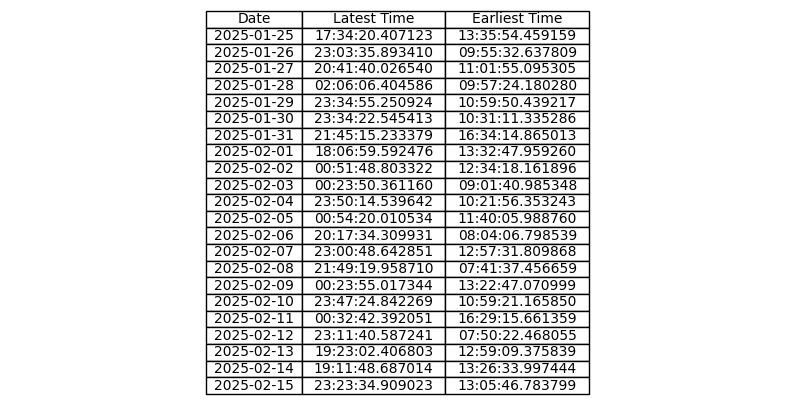

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming sleep_dict is already generated
sleep_dict = estimate_sleep_times(df)

# Convert the sleep_dict into a DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')

# Reset the index to make the dates a separate column
sleep_df.reset_index(inplace=True)
sleep_df.columns = ['Date', 'Latest Time', 'Earliest Time']  # Rename columns to be more readable

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust size as needed

# Hide axes (we want only the table, not the grid or axes)
ax.axis('off')

# Create table in the plot
table = ax.table(cellText=sleep_df.values, colLabels=sleep_df.columns, cellLoc='center', loc='center')

# Optional: Customize the table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])  # Adjust column width if needed

# Save the table as an image (PNG, JPG, etc.)
plt.savefig('sleep_table_image_with_dates.png', bbox_inches='tight', dpi=300)

# Optional: Display the table (just for previewing)
plt.show()


In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# Convert time to decimal hours
def time_to_hours(t):
    return t.hour + t.minute / 60 + t.second / 3600

# Convert sleep dictionary into DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Convert times to decimal hours
sleep_df['latest_hour'] = sleep_df['latest_time'].apply(time_to_hours)
sleep_df['earliest_hour'] = sleep_df['earliest_time'].apply(time_to_hours)

# Initialize lists for plotting
dates = sleep_df.index.strftime('%Y-%m-%d')  # Convert dates to strings for plotting
sleep_start = []  # Start times for bars
sleep_duration = []  # Durations of sleep
split_duration = []  # Second half of sleep if past midnight

# Process each entry for visualization
for _, row in sleep_df.iterrows():
    if row['latest_hour'] >= 14:  # If sleep started late and crossed midnight
        sleep_start.append(row['latest_hour'])  # Sleep start time (e.g., 23:52)
        sleep_duration.append(24 - row['latest_hour'])  # Until midnight
        split_duration.append(row['earliest_hour'])  # From midnight to wake time
    else:  # If sleep was fully after midnight (easier case)
        sleep_start.append(row['latest_hour'])
        sleep_duration.append(row['earliest_hour'] - row['latest_hour'])
        split_duration.append(0)  # No second segment

# Plot the sleep schedule
fig, ax = plt.subplots(figsize=(12, 6))

# Plot first part of sleep (before midnight)
ax.bar(dates, sleep_duration, bottom=sleep_start, color='cornflowerblue')

# Plot second part of sleep (next day)
ax.bar(dates, split_duration, bottom=0, color='cornflowerblue')


# Formatting
ax.set_xlabel('Date')
ax.set_ylabel('Time of Day (Hours)')
ax.set_title('Estimated Sleep Periods Over the Month')
ax.set_yticks(range(0, 25, 2))
ax.set_ylim(0, 24)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

plt.show()


In [90]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Function to calculate sleep duration in hours
def calculate_sleep_duration(latest_time, earliest_time):
    latest_dt = datetime.combine(datetime.today(), latest_time)
    earliest_dt = datetime.combine(datetime.today(), earliest_time)
    
    # Handle crossing midnight
    if earliest_dt < latest_dt:
        earliest_dt += pd.Timedelta(days=1)
    
    duration = (earliest_dt - latest_dt).total_seconds() / 3600  # Convert seconds to hours
    return duration

# Convert sleep dictionary into DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Calculate sleep duration for each day
sleep_df['duration'] = sleep_df.apply(lambda row: calculate_sleep_duration(row['latest_time'], row['earliest_time']), axis=1)

# Extract the day of the week (0=Monday, 6=Sunday)
sleep_df['day_of_week'] = sleep_df.index.day_name()

# Scatter plot of sleep duration by day of the week
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual data points for each day of the week
ax.scatter(sleep_df['day_of_week'], sleep_df['duration'], color='cornflowerblue', s=100, label='Sleep Duration')

# Annotate each point with the date and sleep duration
for i, row in sleep_df.iterrows():
    ax.annotate(f"{row.name.strftime('%Y-%m-%d')}",
                (row['day_of_week'], row['duration']),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Formatting
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Sleep Duration (Hours)')
ax.set_title('Inferred Sleep Duration by Day of the Week')
ax.set_ylim(0, 24)

# Show grid lines
ax.grid(True)


# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()


In [91]:
print("Mean of Inferred Sleep",sleep_df["duration"].mean())

overall_median = sleep_df['duration'].median()
overall_Q1 = sleep_df['duration'].quantile(0.25)
overall_Q3 = sleep_df['duration'].quantile(0.75)

# Display results
print(f"Overall Median Sleep Duration: {overall_median:.2f} hours")
print(f"Overall Q1 (25th percentile): {overall_Q1:.2f} hours")
print(f"Overall Q3 (75th percentile): {overall_Q3:.2f} hours")

Mean of Inferred Sleep 13.147023071224748
Overall Median Sleep Duration: 11.74 hours
Overall Q1 (25th percentile): 10.79 hours
Overall Q3 (75th percentile): 15.54 hours


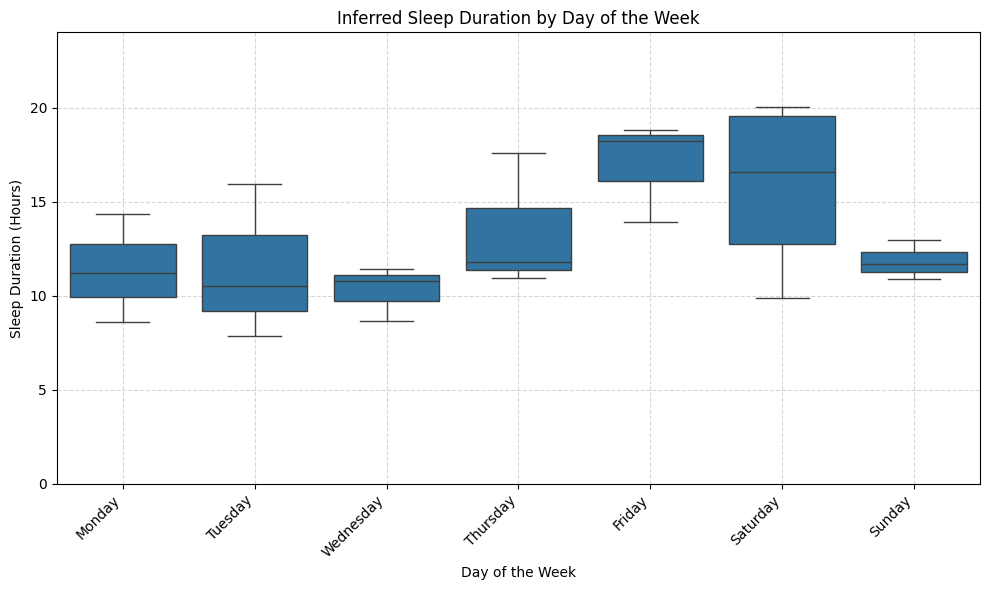

In [92]:
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Calculate sleep duration for each day
sleep_df['duration'] = sleep_df.apply(lambda row: calculate_sleep_duration(row['latest_time'], row['earliest_time']), axis=1)

# Extract the day of the week (Monday-Sunday)
sleep_df['day_of_week'] = sleep_df.index.day_name()

# Sort days of the week properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='duration', data=sleep_df, order=day_order)

# Formatting
plt.xlabel('Day of the Week')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Inferred Sleep Duration by Day of the Week')
plt.ylim(0, 24)  # Adjust based on sleep duration range
plt.grid(True, linestyle='--', alpha=0.5)

# Clean layout
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# Show plot
plt.show()

In [93]:
# Convert sleep dictionary into DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Calculate sleep duration for each day
sleep_df['duration'] = sleep_df.apply(lambda row: calculate_sleep_duration(row['latest_time'], row['earliest_time']), axis=1)

# Add a column for the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
sleep_df['day_of_week'] = sleep_df.index.weekday

# Define colors for each day of the week
day_colors = {
    0: 'blue',    # Monday
    1: 'green',   # Tuesday
    2: 'red',     # Wednesday
    3: 'orange',  # Thursday
    4: 'purple',  # Friday
    5: 'pink',    # Saturday
    6: 'gray'     # Sunday
}

# Get colors for each day based on the 'day_of_week' column
sleep_df['color'] = sleep_df['day_of_week'].map(day_colors)

# Plotting the sleep duration with day-of-week coloring
plt.figure(figsize=(10, 6))
plt.scatter(sleep_df.index, sleep_df['duration'], c=sleep_df['color'])

# Adding labels and title
plt.title('Inferred Sleep Duration Throughout the Month')
plt.xlabel('Date')
plt.ylabel('Sleep Duration (Hours)')


# Rotate date labels for better visibility
plt.xticks(rotation=45, ha='right')

# Create a custom legend
legend_labels = {
    'Monday': 'blue',
    'Tuesday': 'green',
    'Wednesday': 'red',
    'Thursday': 'orange',
    'Friday': 'purple',
    'Saturday': 'pink',
    'Sunday': 'gray'
}

# Add legend for each day
for day, color in legend_labels.items():
    plt.scatter([], [], color=color, label=day)

# Show legend
plt.legend(title="Day of the Week")

for i, row in sleep_df.iterrows():
    plt.text(row.name, row['duration'], f'{row.name.strftime("%Y-%m-%d")}', 
             fontsize=8, ha='center', va='bottom')


# Display the plot
plt.tight_layout()
plt.show()

Looking at Ground Truth Data

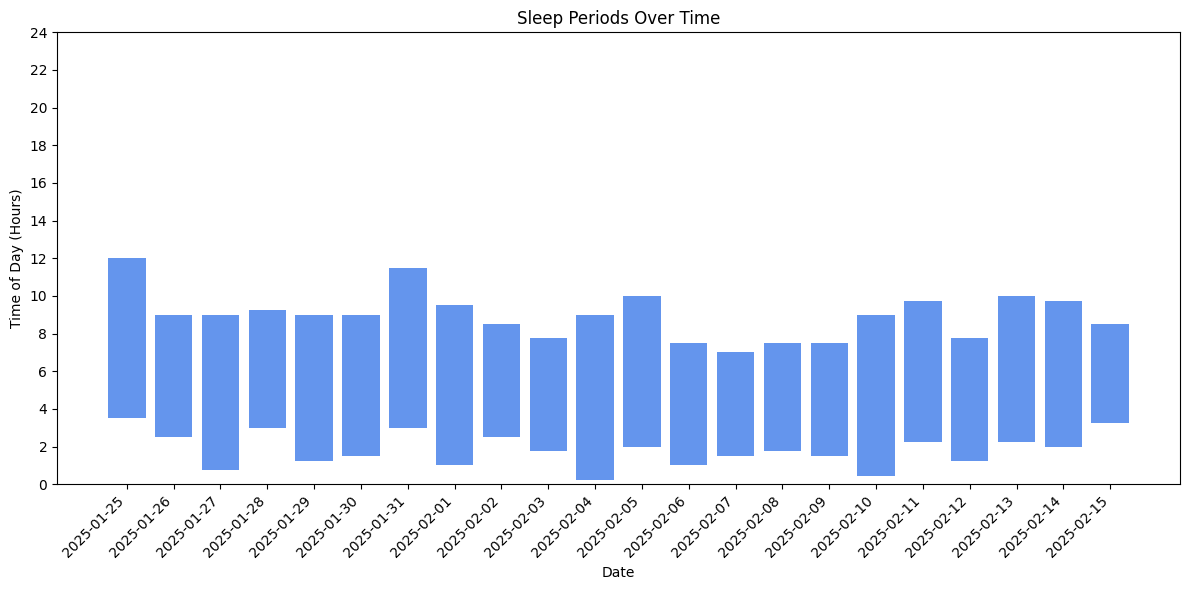

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load CSV data
t_df = pd.read_csv("Project1_Ground_Truth.csv", parse_dates=["Date"]) 

# Convert date column to datetime

# Convert time columns to datetime.time
t_df['Sleep Time'] = pd.to_datetime(t_df['Sleep Time'], format='%H:%M').dt.time
t_df['Wake Time'] = pd.to_datetime(t_df['Wake Time'], format='%H:%M').dt.time

# Function to convert time to decimal hours
def time_to_hours(t):
    return t.hour + t.minute / 60

# Apply function to convert sleep and wake times
t_df['Sleep Hour'] = t_df['Sleep Time'].apply(time_to_hours)
t_df['Wake Hour'] = t_df['Wake Time'].apply(time_to_hours)

# Compute sleep duration
t_df['Sleep Duration'] = t_df['Wake Hour'] - t_df['Sleep Hour']

# Handle cases where sleep goes past midnight
t_df.loc[t_df['Sleep Duration'] < 0, 'Sleep Duration'] += 24

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(t_df['Date'].dt.strftime('%Y-%m-%d'), t_df['Sleep Duration'], bottom=t_df['Sleep Hour'], color='cornflowerblue')

# Formatting
plt.xlabel("Date")
plt.ylabel("Time of Day (Hours)")
plt.title("Sleep Periods Over Time")
plt.xticks(rotation=45, ha='right')  # Rotate dates for readability
plt.yticks(range(0, 25, 2))  # Time in hours
plt.ylim(0, 24)

# Show plot
plt.tight_layout()
plt.show()


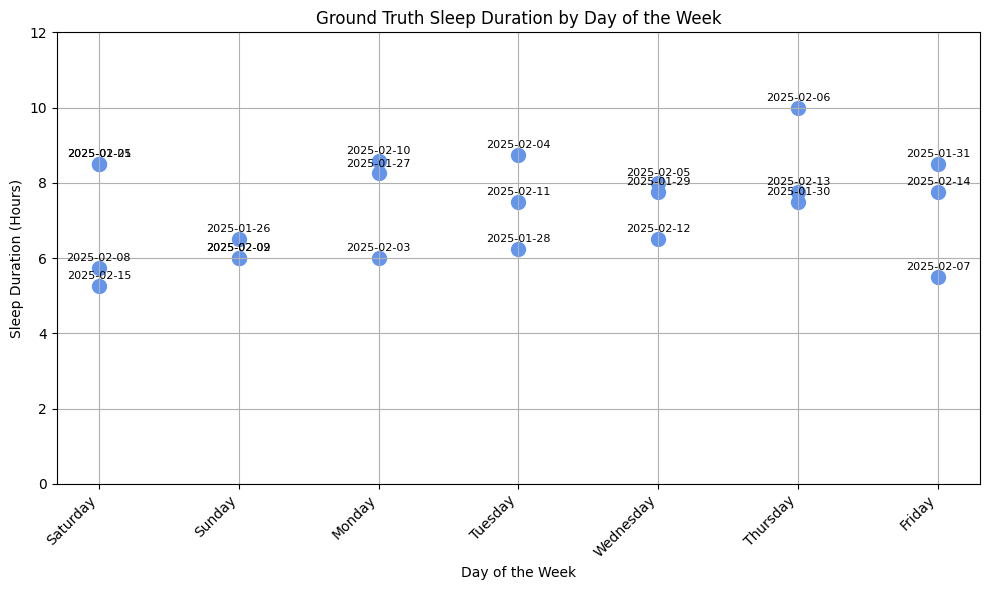

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV data, ensuring 'Date' is parsed as a datetime object
t_df = pd.read_csv("Project1_Ground_Truth.csv", parse_dates=["Date"])

# Extract day of the week
t_df['day_of_week'] = t_df['Date'].dt.day_name()

# Convert Sleep Duration (H:MM) to decimal hours
t_df['Sleep Duration'] = t_df['Sleep Duration'].astype(str).str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)

# Scatter plot of sleep duration by day of the week
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual data points for each day of the week
ax.scatter(t_df['day_of_week'], t_df['Sleep Duration'], color='cornflowerblue', s=100, label='Sleep Duration')

# Annotate each point with the date
for i, row in t_df.iterrows():
    ax.annotate(f"{row['Date'].strftime('%Y-%m-%d')}",
                (row['day_of_week'], row['Sleep Duration']),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Formatting
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Sleep Duration (Hours)')
ax.set_title('Ground Truth Sleep Duration by Day of the Week')
ax.set_ylim(0, 12)  # Adjust based on max sleep duration
ax.grid(True)

# Clean layout
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# Show plot
plt.show()


In [96]:
print("Mean of Inferred Sleep",t_df['Sleep Duration'].mean())

overall_median = t_df['Sleep Duration'].median()
overall_Q1 = t_df['Sleep Duration'].quantile(0.25)
overall_Q3 = t_df['Sleep Duration'].quantile(0.75)

# Display results
print(f"Overall Median Sleep Duration: {overall_median:.2f} hours")
print(f"Overall Q1 (25th percentile): {overall_Q1:.2f} hours")
print(f"Overall Q3 (75th percentile): {overall_Q3:.2f} hours")

Mean of Inferred Sleep 7.321969696969696
Overall Median Sleep Duration: 7.62 hours
Overall Q1 (25th percentile): 6.06 hours
Overall Q3 (75th percentile): 8.44 hours


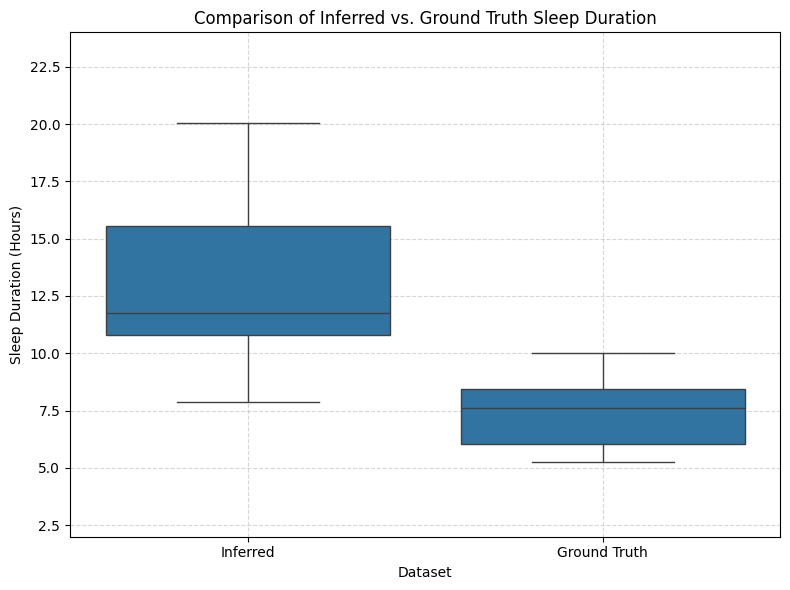

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to store both datasets for comparison
comparison_df = pd.DataFrame({
    'Sleep Duration': pd.concat([sleep_df['duration'], t_df['Sleep Duration']], ignore_index=True),
    'Dataset': ['Inferred'] * len(sleep_df) + ['Ground Truth'] * len(t_df)
})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Dataset', y='Sleep Duration', data=comparison_df)

# Formatting
plt.xlabel('Dataset')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Comparison of Inferred vs. Ground Truth Sleep Duration')
plt.ylim(2, 24)  # Adjust based on sleep duration range
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()


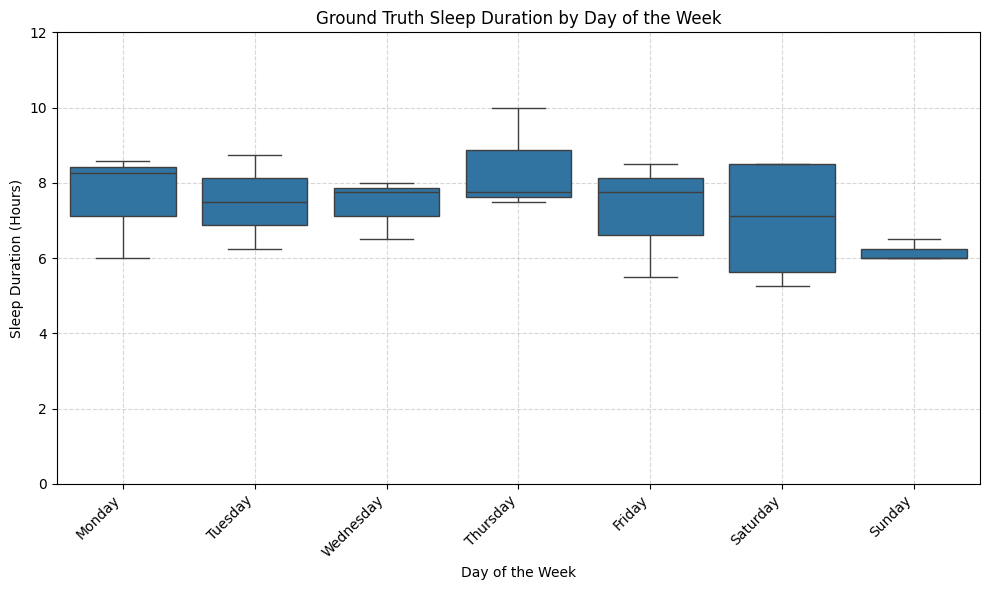

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV data, ensuring 'Date' is parsed as a datetime object
t_df = pd.read_csv("Project1_Ground_Truth.csv", parse_dates=["Date"])

# Extract day of the week
t_df['day_of_week'] = t_df['Date'].dt.day_name()

# Convert Sleep Duration (H:MM) to decimal hours
t_df['Sleep Duration'] = t_df['Sleep Duration'].astype(str).str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)

# Sort days of the week in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='Sleep Duration', data=t_df, order=day_order,)

# Formatting
plt.xlabel('Day of the Week')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Ground Truth Sleep Duration by Day of the Week')
plt.ylim(0, 12)  # Adjust based on max sleep duration
plt.grid(True, linestyle='--', alpha=0.5)

# Clean layout
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# Show plot
plt.show()


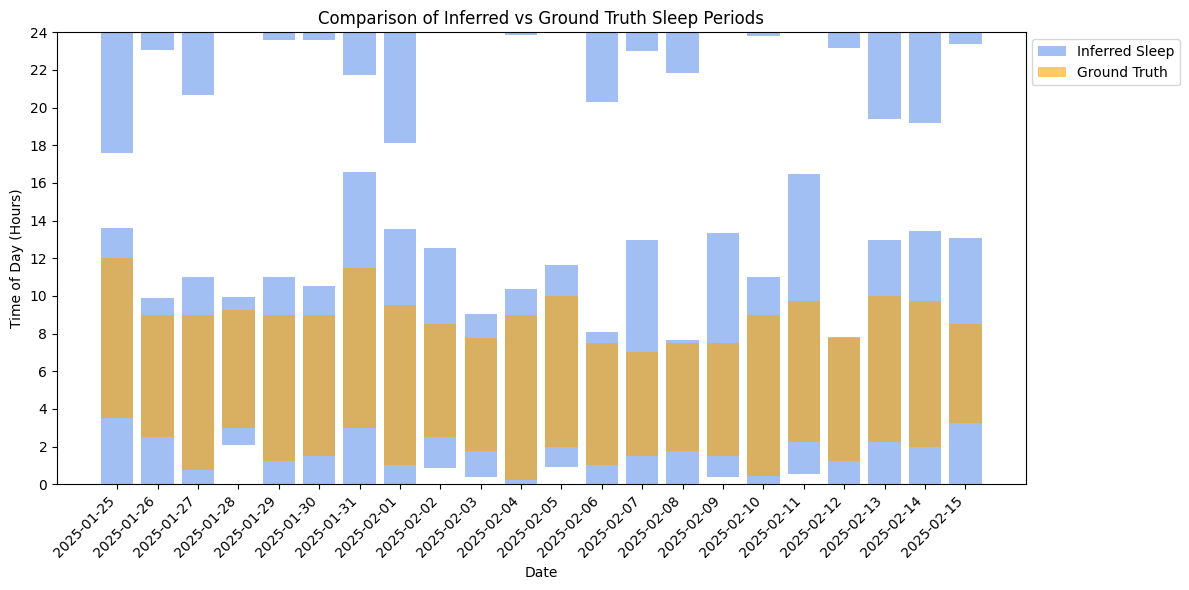

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load ground truth CSV
t_df = pd.read_csv("Project1_Ground_Truth.csv", parse_dates=["Date"]) 

# Convert time columns to datetime.time
t_df['Sleep Time'] = pd.to_datetime(t_df['Sleep Time'], format='%H:%M').dt.time
t_df['Wake Time'] = pd.to_datetime(t_df['Wake Time'], format='%H:%M').dt.time

# Convert sleep dictionary into DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Function to convert time to decimal hours
def time_to_hours(t):
    return t.hour + t.minute / 60

# Apply function to convert times
t_df['Sleep Hour'] = t_df['Sleep Time'].apply(time_to_hours)
t_df['Wake Hour'] = t_df['Wake Time'].apply(time_to_hours)
sleep_df['latest_hour'] = sleep_df['latest_time'].apply(time_to_hours)
sleep_df['earliest_hour'] = sleep_df['earliest_time'].apply(time_to_hours)

# Compute sleep duration
t_df['Sleep Duration'] = t_df['Wake Hour'] - t_df['Sleep Hour']
t_df.loc[t_df['Sleep Duration'] < 0, 'Sleep Duration'] += 24  # Adjust for past-midnight sleep

# Initialize lists for inferred sleep plotting
dates = sleep_df.index.strftime('%Y-%m-%d')
sleep_start = []
sleep_duration = []
split_duration = []

# Process inferred sleep data
for _, row in sleep_df.iterrows():
    if row['latest_hour'] >= 14:  # If sleep started late and crossed midnight
        sleep_start.append(row['latest_hour'])
        sleep_duration.append(24 - row['latest_hour'])
        split_duration.append(row['earliest_hour'])
    else:  # Sleep fully after midnight
        sleep_start.append(row['latest_hour'])
        sleep_duration.append(row['earliest_hour'] - row['latest_hour'])
        split_duration.append(0)

# Start plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot inferred sleep (light blue)
ax.bar(dates, sleep_duration, bottom=sleep_start, color='cornflowerblue', alpha=0.6, label="Inferred Sleep")
ax.bar(dates, split_duration, bottom=0, color='cornflowerblue', alpha=0.6)

# Plot ground truth sleep (orange)
ax.bar(t_df['Date'].dt.strftime('%Y-%m-%d'), t_df['Sleep Duration'], bottom=t_df['Sleep Hour'], color='orange', alpha=0.6, label="Ground Truth")

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Time of Day (Hours)")
ax.set_title("Comparison of Inferred vs Ground Truth Sleep Periods")
ax.set_yticks(range(0, 25, 2))
ax.set_ylim(0, 24)
plt.xticks(rotation=45, ha='right')

# Legend
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show plot
plt.tight_layout()
plt.show()


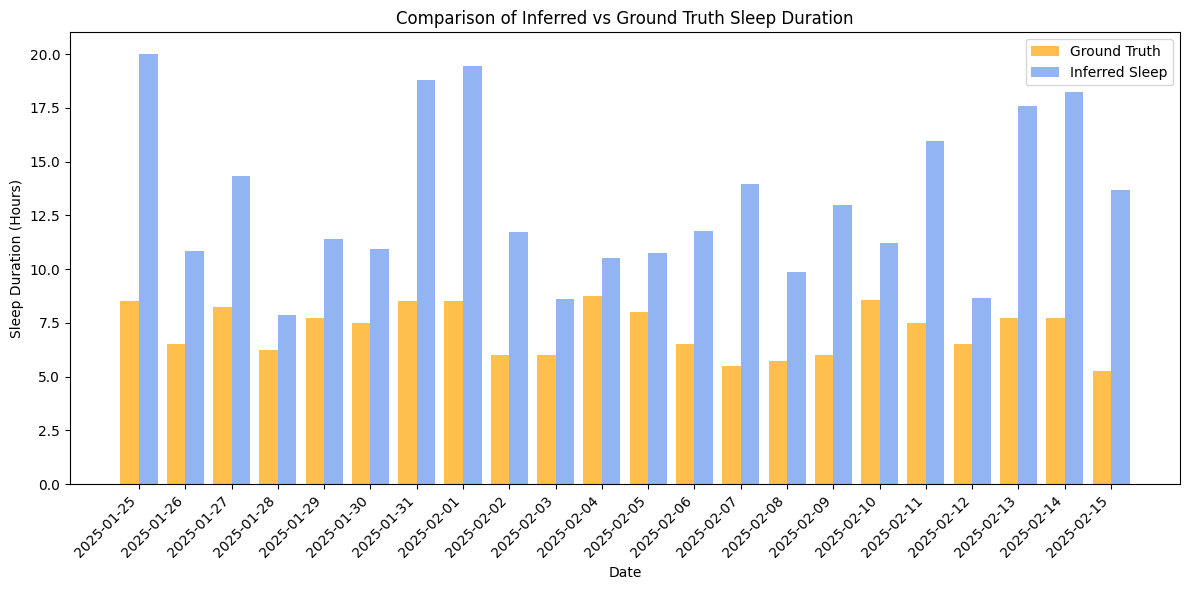

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load ground truth CSV
t_df = pd.read_csv("Project1_Ground_Truth.csv", parse_dates=["Date"]) 

# Convert time columns to datetime.time
t_df['Sleep Time'] = pd.to_datetime(t_df['Sleep Time'], format='%H:%M').dt.time
t_df['Wake Time'] = pd.to_datetime(t_df['Wake Time'], format='%H:%M').dt.time

# Convert sleep dictionary into DataFrame
sleep_df = pd.DataFrame.from_dict(sleep_dict, orient='index')
sleep_df.index = pd.to_datetime(sleep_df.index)  # Convert index to datetime format
sleep_df.sort_index(inplace=True)

# Function to convert time to decimal hours
def time_to_hours(t):
    return t.hour + t.minute / 60

# Apply function to convert times
t_df['Sleep Hour'] = t_df['Sleep Time'].apply(time_to_hours)
t_df['Wake Hour'] = t_df['Wake Time'].apply(time_to_hours)
sleep_df['latest_hour'] = sleep_df['latest_time'].apply(time_to_hours)
sleep_df['earliest_hour'] = sleep_df['earliest_time'].apply(time_to_hours)

# Compute sleep duration
t_df['Sleep Duration'] = t_df['Wake Hour'] - t_df['Sleep Hour']
t_df.loc[t_df['Sleep Duration'] < 0, 'Sleep Duration'] += 24  # Adjust for past-midnight sleep

# Compute inferred sleep duration
sleep_df['Sleep Duration'] = sleep_df['earliest_hour'] - sleep_df['latest_hour']
sleep_df.loc[sleep_df['Sleep Duration'] < 0, 'Sleep Duration'] += 24  # Adjust for past-midnight sleep

# Align data by date
t_df['Date_str'] = t_df['Date'].dt.strftime('%Y-%m-%d')
sleep_df['Date_str'] = sleep_df.index.strftime('%Y-%m-%d')

# Merge data to ensure dates align correctly
merged_df = pd.merge(t_df[['Date_str', 'Sleep Duration']], sleep_df[['Date_str', 'Sleep Duration']], on="Date_str", suffixes=('_truth', '_inferred'), how='outer')

# Sort by date
merged_df = merged_df.sort_values(by="Date_str")

# Convert NaN to 0 for missing data
merged_df.fillna(0, inplace=True)

# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar positions
x_labels = merged_df["Date_str"]
x = np.arange(len(x_labels))  # Numeric positions for bars
width = 0.4  # Width of bars

# Plot ground truth
ax.bar(x - width/2, merged_df['Sleep Duration_truth'], width=width, color='orange', alpha=0.7, label="Ground Truth")

# Plot inferred sleep
ax.bar(x + width/2, merged_df['Sleep Duration_inferred'], width=width, color='cornflowerblue', alpha=0.7, label="Inferred Sleep")

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Sleep Duration (Hours)")
ax.set_title("Comparison of Inferred vs Ground Truth Sleep Duration")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [101]:
category_counts = df.groupby(['date', 'Category']).size().unstack(fill_value=0)

# Reset index so that 'date' becomes a column again
category_counts.reset_index(inplace=True)

merged_df['Date_str'] = pd.to_datetime(merged_df['Date_str']).dt.strftime('%Y-%m-%d')
category_counts['date'] = pd.to_datetime(merged_df['Date_str']).dt.strftime('%Y-%m-%d')

# Merge the category counts with merged_df based on the 'Date_str'
merged_df = pd.merge(merged_df, category_counts, left_on='Date_str', right_on='date', how='left')

# Drop the 'date' column from the merge since it's no longer needed
merged_df.drop(columns=['date'], inplace=True)


In [102]:
# Group by "date" and count the queries
query_counts = df.groupby("date").size()

# Reset the index of query_counts and rename the columns
query_counts = query_counts.reset_index(name='Total Queries')

# Convert 'Date_str' to the correct format in merged_df
merged_df['Date_str'] = pd.to_datetime(merged_df['Date_str']).dt.strftime('%Y-%m-%d')
query_counts['date'] = pd.to_datetime(merged_df['Date_str']).dt.strftime('%Y-%m-%d')
# Perform the inner merge on 'Date_str'
merged_df = pd.merge(merged_df, query_counts, left_on='Date_str', right_on='date', how='inner')

# Drop the 'date' column from the merge (since it’s no longer needed)
merged_df.drop(columns=['date'], inplace=True)


In [103]:
sleep_df.head()
merged_df = pd.merge(merged_df, sleep_df[['Date_str', 'earliest_time', 'latest_time']], on='Date_str', how='left')
merged_df.dtypes

def time_to_decimal_hours(t):
    return t.hour + t.minute / 60 + t.second / 3600

# Convert 'earliest_time' to decimal hours
merged_df['earliest_time'] = merged_df['earliest_time'].apply(time_to_decimal_hours)
merged_df['latest_time'] = merged_df['latest_time'].apply(time_to_decimal_hours)

merged_df.rename(columns={'earliest_time': 'inferred_earliest_time', 'latest_time': 'inferred_latest_time'}, inplace=True)


In [104]:
t_df

Date Sleep Time Wake Time  Sleep Duration                   Notes  \
0  2025-01-25   03:30:00  12:00:00        8.500000  Small Sleep Disruption   
1  2025-01-26   02:30:00  09:00:00        6.500000  Small Sleep Disruption   
2  2025-01-27   00:45:00  09:00:00        8.250000  Small Sleep Disruption   
3  2025-01-28   03:00:00  09:15:00        6.250000  Small Sleep Disruption   
4  2025-01-29   01:15:00  09:00:00        7.750000                     NaN   
5  2025-01-30   01:30:00  09:00:00        7.500000                     NaN   
6  2025-01-31   03:00:00  11:30:00        8.500000                     NaN   
7  2025-02-01   01:00:00  09:30:00        8.500000                     NaN   
8  2025-02-02   02:30:00  08:30:00        6.000000  Small Sleep Disruption   
9  2025-02-03   01:45:00  07:45:00        6.000000                     NaN   
10 2025-02-04   00:15:00  09:00:00        8.750000                     NaN   
11 2025-02-05   02:00:00  10:00:00        8.000000                     NaN   
12 2025-02-06   01:00:00  07:30:00        6.500000                     NaN   
13 2025-02-07   01:30:00  07:00:00        5.500000                     NaN   
14 2025-02-08   01:45:00  07:30:00        5.750000                     NaN   
15 2025-02-09   01:30:00  07:30:00        6.000000                     NaN   
16 2025-02-10   00:25:00  09:00:00        8.583333  Small Sleep Disruption   
17 2025-02-11   02:15:00  09:45:00        7.500000                     NaN   
18 2025-02-12   01:15:00  07:45:00        6.500000  Small Sleep Disruption   
19 2025-02-13   02:15:00  10:00:00        7.750000  Small Sleep Disruption   
20 2025-02-14   02:00:00  09:45:00        7.750000                     NaN   
21 2025-02-15   03:15:00  08:30:00        5.250000        Sleep Disruption   

    Sleep Hour  Wake Hour    Date_str  
0     3.500000      12.00  2025-01-25  
1     2.500000       9.00  2025-01-26  
2     0.750000       9.00  2025-01-27  
3     3.000000       9.25  2025-01-28  
4     1.250000       9.00  2025-01-29  
5     1.500000       9.00  2025-01-30  
6     3.000000      11.50  2025-01-31  
7     1.000000       9.50  2025-02-01  
8     2.500000       8.50  2025-02-02  
9     1.750000       7.75  2025-02-03  
10    0.250000       9.00  2025-02-04  
11    2.000000      10.00  2025-02-05  
12    1.000000       7.50  2025-02-06  
13    1.500000       7.00  2025-02-07  
14    1.750000       7.50  2025-02-08  
15    1.500000       7.50  2025-02-09  
16    0.416667       9.00  2025-02-10  
17    2.250000       9.75  2025-02-11  
18    1.250000       7.75  2025-02-12  
19    2.250000      10.00  2025-02-13  
20    2.000000       9.75  2025-02-14  
21    3.250000       8.50  2025-02-15

In [105]:
merged_df = pd.merge(merged_df, t_df[['Date_str', 'Sleep Time', 'Wake Time']], on='Date_str', how='left')

merged_df['Sleep Time'] = merged_df['Sleep Time'].apply(time_to_decimal_hours)
merged_df['Wake Time'] = merged_df['Wake Time'].apply(time_to_decimal_hours)

merged_df.rename(columns={'Wake Time': 'actual_earliest_time', 'Sleep Time': 'actual_latest_time'}, inplace=True)


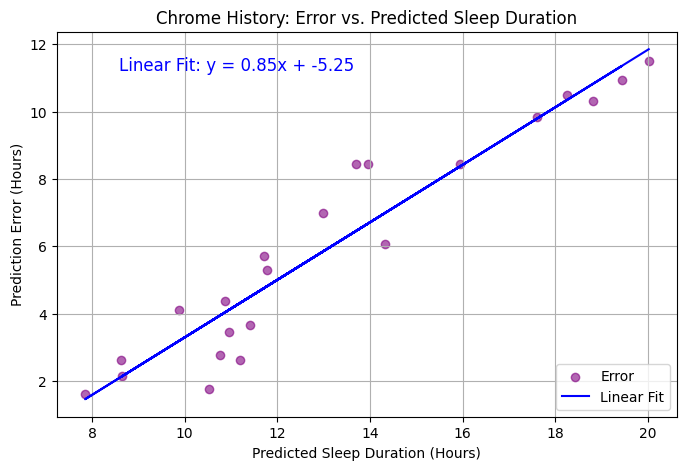

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Compute absolute error
merged_df["Error"] = abs(merged_df["Sleep Duration_inferred"] - merged_df["Sleep Duration_truth"])

# Fit a linear trend line
z_lin = np.polyfit(merged_df["Sleep Duration_inferred"], merged_df["Error"], 1)
p_lin = np.poly1d(z_lin)(merged_df["Sleep Duration_inferred"])

# Extract coefficients for linear model
slope, intercept = z_lin  # Linear fit: y = mx + b

# Prepare the equation as text
linear_eq = f"Linear Fit: y = {slope:.2f}x + {intercept:.2f}"

# Plot the data and linear fit
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["Sleep Duration_inferred"], merged_df["Error"], alpha=0.6, color='purple', label='Error')

# Plot the linear fit
plt.plot(merged_df["Sleep Duration_inferred"], p_lin, color='blue', linestyle='solid', label='Linear Fit')

# Add the linear equation as text on the plot
plt.text(0.1, 0.9, linear_eq, transform=plt.gca().transAxes, fontsize=12, color='blue')

# Labels and title
plt.xlabel("Predicted Sleep Duration (Hours)")
plt.ylabel("Prediction Error (Hours)")
plt.title("Chrome History: Error vs. Predicted Sleep Duration")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(merged_df['Sleep Duration_truth'], merged_df['Sleep Duration_inferred'])
mse = mean_squared_error(merged_df['Sleep Duration_truth'], merged_df['Sleep Duration_inferred'])
rmse = np.sqrt(mse)
correlation = np.corrcoef(merged_df['Sleep Duration_truth'], merged_df['Sleep Duration_inferred'])[0, 1]

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f} hours")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} hours")
print(f"Correlation Coefficient: {correlation:.2f}")

Mean Absolute Error (MAE): 5.98 hours
Root Mean Squared Error (RMSE): 6.81 hours
Correlation Coefficient: 0.47


In [108]:
numeric_df = merged_df.select_dtypes(include=[np.number])

# Compute correlation with 'Sleep Duration_truth'
numeric_df.corr()['Sleep Duration_truth'].sort_values()


actual_latest_time        -0.266224
Total Queries             -0.124328
Google Search             -0.115144
Entertainment/Shopping    -0.114966
Productivity              -0.113327
Other                      0.048300
Error                      0.177776
inferred_latest_time       0.234387
inferred_earliest_time     0.319695
Sleep Duration_inferred    0.469642
actual_earliest_time       0.724563
Sleep Duration_truth       1.000000
Name: Sleep Duration_truth, dtype: float64

In [109]:
numeric_df.corr()['Sleep Duration_inferred'].sort_values()

Total Queries             -0.362255
Productivity              -0.328206
Google Search             -0.291797
Other                     -0.260700
Entertainment/Shopping    -0.102293
inferred_latest_time       0.167130
actual_latest_time         0.286934
Sleep Duration_truth       0.469642
actual_earliest_time       0.634845
inferred_earliest_time     0.779698
Error                      0.952285
Sleep Duration_inferred    1.000000
Name: Sleep Duration_inferred, dtype: float64

In [111]:
numeric_df.corr()['actual_earliest_time'].sort_values()

Total Queries             -0.192022
Productivity              -0.185962
Other                     -0.156702
Google Search             -0.058287
Entertainment/Shopping    -0.045273
inferred_latest_time       0.017158
Error                      0.457139
actual_latest_time         0.471440
inferred_earliest_time     0.584532
Sleep Duration_inferred    0.634845
Sleep Duration_truth       0.724563
actual_earliest_time       1.000000
Name: actual_earliest_time, dtype: float64

In [112]:
numeric_df.corr()['actual_latest_time'].sort_values()

Other                     -0.280963
inferred_latest_time      -0.275921
Sleep Duration_truth      -0.266224
Productivity              -0.115070
Total Queries             -0.109470
Google Search              0.065817
Entertainment/Shopping     0.083790
Sleep Duration_inferred    0.286934
inferred_earliest_time     0.408438
Error                      0.411865
actual_earliest_time       0.471440
actual_latest_time         1.000000
Name: actual_latest_time, dtype: float64

In [110]:
merged_df

Date_str  Sleep Duration_truth  Sleep Duration_inferred  \
0   2025-01-25              8.500000                20.016667   
1   2025-01-26              6.500000                10.866667   
2   2025-01-27              8.250000                14.333333   
3   2025-01-28              6.250000                 7.850000   
4   2025-01-29              7.750000                11.416667   
5   2025-01-30              7.500000                10.950000   
6   2025-01-31              8.500000                18.816667   
7   2025-02-01              8.500000                19.433333   
8   2025-02-02              6.000000                11.716667   
9   2025-02-03              6.000000                 8.633333   
10  2025-02-04              8.750000                10.516667   
11  2025-02-05              8.000000                10.766667   
12  2025-02-06              6.500000                11.783333   
13  2025-02-07              5.500000                13.950000   
14  2025-02-08              5.750000                 9.866667   
15  2025-02-09              6.000000                12.983333   
16  2025-02-10              8.583333                11.200000   
17  2025-02-11              7.500000                15.950000   
18  2025-02-12              6.500000                 8.650000   
19  2025-02-13              7.750000                17.600000   
20  2025-02-14              7.750000                18.250000   
21  2025-02-15              5.250000                13.700000   

    Entertainment/Shopping  Google Search  Other  Productivity  Total Queries  \
0                        3              4      2            19             28   
1                        0             62     26           128            216   
2                        0             30     24            96            150   
3                        3             31     31           143            208   
4                        8             62     23           150            243   
5                       82             68     31           288            469   
6                        3             38     33           161            235   
7                        0             15     10            40             65   
8                       16            197     24           159            396   
9                       13             67     49          1579           1708   
10                       7             52     74           384            517   
11                       4             31     15           260            310   
12                      19              8     10           115            152   
13                       0             10     40            69            119   
14                       5             16     45           155            221   
15                       0              3     17            49             69   
16                       4             27     22           379            432   
17                      26             17     40            92            175   
18                       9             24     19           229            281   
19                      17             24     46           276            363   
20                      11             21     25           425            482   
21                      39             11      4           213            267   

    inferred_earliest_time  inferred_latest_time  actual_latest_time  \
0                13.598333             17.572222            3.500000   
1                 9.925556             23.059722            2.500000   
2                11.031944             20.694444            0.750000   
3                 9.956667              2.101667            3.000000   
4                10.997222             23.581944            1.250000   
5                10.519722             23.572778            1.500000   
6                16.570556             21.754167            3.000000   
7                13.546389             18.116389            1.000000  